# RNNs

In this notebook you will learn how to build Recurrent Neural Networks (RNNs) for time series forecasting and sequence classification.

## Imports

In [87]:
%matplotlib inline

In [88]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [89]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.3 (default, Apr  3 2019, 05:39:12) 
[GCC 8.3.0]
matplotlib 3.1.0
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-dev20190623
tensorflow_core.keras 2.2.4-tf


In [90]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 1 – Time series forecasting

## 1.1) Load the data

Let's start with a simple univariate time series: the daily temperatures in Melbourne from 1981 to 1990 ([source](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990)).

In [91]:
temps = pd.read_csv("datasets/daily-minimum-temperatures-in-me.csv",
                    parse_dates=[0], index_col=0)

In [92]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


In [93]:
temps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


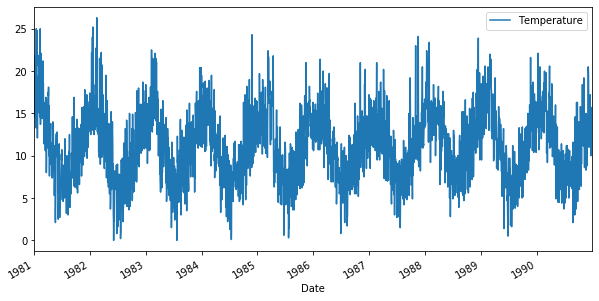

In [94]:
temps.plot(figsize=(10,5))
plt.show()

## 1.2) Prepare the data

A few dates are missing, for example December 31st, 1984:

In [95]:
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1985-01-01,13.3
1985-01-02,15.2


Let's ensure there's one row per day, filling missing values with the previous valid value:

In [96]:
temps = temps.asfreq("1D", method="ffill")
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1984-12-31,16.4
1985-01-01,13.3
1985-01-02,15.2


Alternatively, we could have interpolated using `temps.interpolate()`.

## 1.3) Add the shifted columns

Next, let's create a function to add lag columns:

In [97]:
def add_lags(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

We will try to predict the temperature in 5 days (t+5) using the temperatures from the last 30 days (t-29 to t):

In [98]:
X = add_lags(temps, times=range(-30+1,1)).iloc[30:-5]
y = add_lags(temps, times=[5]).iloc[30:-5]

In [99]:
X.head()

,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,...,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,12.1,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4
1981-02-01,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3
1981-02-02,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8
1981-02-03,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9
1981-02-04,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9,19.9


In [100]:
y.head()

,t+5
,Temperature
Date,
1981-01-31,16.6
1981-02-01,16.8
1981-02-02,14.6
1981-02-03,17.1
1981-02-04,25.0


Note: you may want to use `keras.preprocessing.sequence.TimeseriesGenerator` or `tf.data.Dataset.window()` instead.

In [101]:
"""
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(5))
dataset = dataset.shuffle(10)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.batch(2).prefetch(1) 
for X, y in dataset:
    print(X.numpy(), y.numpy(), end = " ")
"""

'\ndataset = tf.data.Dataset.range(10)\ndataset = dataset.window(5, shift=1, drop_remainder=True)\ndataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(5))\ndataset = dataset.shuffle(10)\ndataset = dataset.map(lambda window: (window[:-1], window[-1]))\ndataset = dataset.batch(2).prefetch(1) \nfor X, y in dataset:\n    print(X.numpy(), y.numpy(), end = " ")\n'

## 1.4) Split the dataset

Split this dataset into three periods: training (1981-1986), validation (1987-1988) and testing (1989-1990).

In [102]:
from datetime import datetime
train_index = (X.index >= datetime(1981, 1, 1)) & (X.index < datetime(1987, 1, 1))
valid_index = (X.index >= datetime(1987, 1, 1)) & (X.index < datetime(1989, 1, 1))
test_index = (X.index >= datetime(1989, 1, 1)) & (X.index < datetime(1991, 1, 1))
X_train = X[train_index]
y_train = y[train_index]
X_valid = X[valid_index]
y_valid = y[valid_index]
X_test = X[test_index] 
y_test = y[test_index]

## 1.5) Reshape the inputs for the RNN

Keras and TensorFlow expect a 3D NumPy array for any sequence. Its shape should be (number of instances, number of time steps, number of features per time step). Since this is a univariate time series, the last dimension is 1. Reshape the input features to get 3D arrays:

In [103]:
#X_train_3D = ...
#X_valid_3D = ...
#X_test_3D = ...

In [104]:
X_train_3D = X_train.values[..., np.newaxis]
X_valid_3D = X_valid.values[..., np.newaxis]
X_test_3D = X_test.values[..., np.newaxis]

In [140]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [142]:
X_train_3D_scaled = X_train_scaled[..., np.newaxis]
X_valid_3D_scaled = X_valid_scaled[..., np.newaxis]
X_test_3D_scaled = X_test_scaled[..., np.newaxis]

In [105]:
X_train_3D.shape

(2161, 30, 1)

In [106]:
y_train.shape

(2161, 1)

## 1.6) Build some baseline models

Build some baseline models (at least one) and evaluate them on the validation set, using the Mean Absolute Error (MAE). For example:

* a naive model, that just predicts the last known value.
* an EMA model that predicts an exponential moving average of the last 48 hours (you can try to find the best span).
* a linear model.

Optional: plot the predictions.

In [62]:
from sklearn.metrics import mean_absolute_error
y_valid_pred_naive = X_valid.iloc[:, -1]
y_test_pred_naive = X_test.iloc[:, -1]
print(mean_absolute_error(y_valid, y_valid_pred_naive), mean_absolute_error(y_test, y_test_pred_naive))

2.978796169630643 2.8064827586206893


In [107]:
from sklearn.linear_model import LassoCV
clf = LassoCV()
clf.fit(X_train, y_train)
y_valid_pred_lasso = clf.predict(X_valid)
y_test_pred_lasso = clf.predict(X_test)
print(mean_absolute_error(y_valid, y_valid_pred_lasso), mean_absolute_error(y_test, y_test_pred_lasso))

2.2582011662546844 2.1123812948060214


/home/yang/Projects/perso/venv/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yang/Projects/perso/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [139]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, max_depth=8, max_features=0.4, n_jobs=-1)
rf.fit(X_train, y_train)
y_valid_pred_rf = rf.predict(X_valid)
y_test_pred_rf = rf.predict(X_test)
print(mean_absolute_error(y_valid, y_valid_pred_rf), mean_absolute_error(y_test, y_test_pred_rf))

/home/yang/Projects/perso/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


2.216000359586706 2.1076757011937293


In [64]:
X_test_3D.shape

(725, 30, 1)

## 1.7) Build a simple RNN

Using Keras, build a simple 2-layer RNN with 100 neurons per layer, plus a dense layer with a single neuron. Train the model for 200 epochs with a batch size of 200, using Stochastic Gradient Descent with an learning rate of 0.005. Make sure to print the validation loss during training.

Hints:

* Create a `Sequential` model.
* Add two `SimpleRNN` layers, with 100 units each. The first should return sequences but not the second. Indeed, in a Seq2Vec model, the last RNN layer should not return sequences. The first layer should specify the input shape (i.e., the shape of a single input sequence).
* Use the MSE as the loss.
* Call the model's `compile()` method, passing it an `SGD` instance with `lr=0.005`.
* Call the model's `fit()` method, with the inputs and targets, number of epochs, batch size and validation data.

In [110]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape = (30, 1)))
model1.add(tf.keras.layers.SimpleRNN(units=100))
model1.add(tf.keras.layers.Dense(1))

In [114]:
model1.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(lr=0.005), metrics = ['mae'])
model1.fit(X_train_3D, y_train, epochs=200, validation_data=(X_valid_3D, y_valid))

Train on 2161 samples, validate on 731 samples
Epoch 1/200
2161/2161 [==============================] - 2s 993us/sample - loss: 9.3912 - mae: 2.4219 - val_loss: 9.6285 - val_mae: 2.4003
Epoch 2/200
2161/2161 [==============================] - 1s 581us/sample - loss: 9.5073 - mae: 2.4097 - val_loss: 8.7901 - val_mae: 2.2929
Epoch 3/200
2161/2161 [==============================] - 1s 591us/sample - loss: 9.7109 - mae: 2.4349 - val_loss: 14.1243 - val_mae: 2.9410
Epoch 4/200
2161/2161 [==============================] - 1s 603us/sample - loss: 9.5476 - mae: 2.4269 - val_loss: 12.0006 - val_mae: 2.6942
Epoch 5/200
2161/2161 [==============================] - 1s 578us/sample - loss: 9.3256 - mae: 2.3846 - val_loss: 8.9447 - val_mae: 2.3431
Epoch 6/200
2161/2161 [==============================] - 1s 564us/sample - loss: 9.3881 - mae: 2.3970 - val_loss: 8.3970 - val_mae: 2.2774
Epoch 7/200
2161/2161 [==============================] - 1s 582us/sample - loss: 9.4693 - mae: 2.4113 - val_loss: 9.0

2161/2161 [==============================] - 1s 592us/sample - loss: 9.4134 - mae: 2.4069 - val_loss: 9.4058 - val_mae: 2.4380
Epoch 60/200
2161/2161 [==============================] - 1s 607us/sample - loss: 9.3852 - mae: 2.4042 - val_loss: 9.0923 - val_mae: 2.3863
Epoch 61/200
2161/2161 [==============================] - 1s 600us/sample - loss: 9.1128 - mae: 2.3607 - val_loss: 8.5959 - val_mae: 2.2870
Epoch 62/200
2161/2161 [==============================] - 1s 594us/sample - loss: 9.1047 - mae: 2.3614 - val_loss: 8.8360 - val_mae: 2.3296
Epoch 63/200
2161/2161 [==============================] - 1s 593us/sample - loss: 9.1017 - mae: 2.3529 - val_loss: 8.4492 - val_mae: 2.2870
Epoch 64/200
2161/2161 [==============================] - 1s 596us/sample - loss: 9.0986 - mae: 2.3631 - val_loss: 9.5213 - val_mae: 2.4390
Epoch 65/200
2161/2161 [==============================] - 1s 594us/sample - loss: 9.1370 - mae: 2.3644 - val_loss: 9.4760 - val_mae: 2.4077
Epoch 66/200
2161/2161 [=========

2161/2161 [==============================] - 1s 656us/sample - loss: 9.6843 - mae: 2.4384 - val_loss: 14.8800 - val_mae: 3.1224
Epoch 118/200
2161/2161 [==============================] - 1s 613us/sample - loss: 10.1525 - mae: 2.4818 - val_loss: 9.6527 - val_mae: 2.4583
Epoch 119/200
2161/2161 [==============================] - 1s 677us/sample - loss: 10.0452 - mae: 2.5036 - val_loss: 12.8014 - val_mae: 2.8150
Epoch 120/200
2161/2161 [==============================] - 1s 646us/sample - loss: 9.9039 - mae: 2.4680 - val_loss: 8.6754 - val_mae: 2.2992
Epoch 121/200
2161/2161 [==============================] - 1s 659us/sample - loss: 9.9407 - mae: 2.4734 - val_loss: 16.7837 - val_mae: 3.3915
Epoch 122/200
2161/2161 [==============================] - 1s 652us/sample - loss: 9.5064 - mae: 2.4114 - val_loss: 8.6175 - val_mae: 2.2708
Epoch 123/200
2161/2161 [==============================] - 1s 630us/sample - loss: 9.7516 - mae: 2.4391 - val_loss: 9.6399 - val_mae: 2.4340
Epoch 124/200
2161/216

Epoch 175/200
2161/2161 [==============================] - 1s 622us/sample - loss: 9.3720 - mae: 2.3986 - val_loss: 8.7118 - val_mae: 2.3003
Epoch 176/200
2161/2161 [==============================] - 1s 649us/sample - loss: 9.5316 - mae: 2.4176 - val_loss: 8.4065 - val_mae: 2.2781
Epoch 177/200
2161/2161 [==============================] - 1s 661us/sample - loss: 9.2140 - mae: 2.3732 - val_loss: 8.7256 - val_mae: 2.2928
Epoch 178/200
2161/2161 [==============================] - 1s 686us/sample - loss: 9.3599 - mae: 2.4085 - val_loss: 9.0699 - val_mae: 2.3362
Epoch 179/200
2161/2161 [==============================] - 2s 715us/sample - loss: 9.1197 - mae: 2.3695 - val_loss: 13.7881 - val_mae: 2.8666
Epoch 180/200
2161/2161 [==============================] - 2s 715us/sample - loss: 9.8636 - mae: 2.4710 - val_loss: 9.2424 - val_mae: 2.3708
Epoch 181/200
2161/2161 [==============================] - 2s 736us/sample - loss: 9.4436 - mae: 2.4081 - val_loss: 8.7623 - val_mae: 2.3214
Epoch 182/20

## 1.8) Plot the history

Recall that you can simply use `pd.DataFrame(history.history).plot()`.

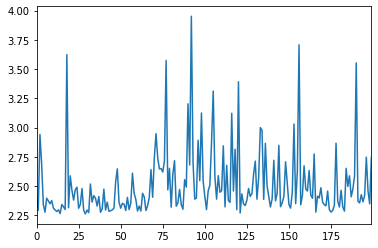

In [117]:
pd.DataFrame(Out[114].history)['val_mae'].plot()

## 1.9) Evaluate the model

Evaluate your RNN on the validation set, using the MAE. Try training your model again using the Huber loss and see if you get better performance.

In [118]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape = (30, 1)))
model2.add(tf.keras.layers.SimpleRNN(units=100))
model2.add(tf.keras.layers.Dense(1))

model2.compile(loss=huber_loss,
               optimizer = tf.keras.optimizers.SGD(lr=0.005), 
               metrics = ['mae'])
model2.fit(X_train_3D, y_train, epochs=50, validation_data=(X_valid_3D, y_valid))

y_valid_test_rnn_model2 = model2.predict(X_test_3D)
print(mean_absolute_error(y_test, y_valid_test_rnn_model2))

Train on 2161 samples, validate on 731 samples
Epoch 1/50
2161/2161 [==============================] - 2s 719us/sample - loss: 3.4372 - mae: 3.9073 - val_loss: 2.2555 - val_mae: 2.7148
Epoch 2/50
2161/2161 [==============================] - 1s 366us/sample - loss: 2.1932 - mae: 2.6525 - val_loss: 1.8883 - val_mae: 2.3453
Epoch 3/50
2161/2161 [==============================] - 1s 368us/sample - loss: 2.0369 - mae: 2.4891 - val_loss: 1.8721 - val_mae: 2.3319
Epoch 4/50
2161/2161 [==============================] - 1s 374us/sample - loss: 1.9788 - mae: 2.4367 - val_loss: 1.8559 - val_mae: 2.3107
Epoch 5/50
2161/2161 [==============================] - 1s 377us/sample - loss: 1.9651 - mae: 2.4204 - val_loss: 1.8402 - val_mae: 2.2956
Epoch 6/50
2161/2161 [==============================] - 1s 357us/sample - loss: 1.9693 - mae: 2.4267 - val_loss: 1.8812 - val_mae: 2.3374
Epoch 7/50
2161/2161 [==============================] - 1s 354us/sample - loss: 1.9238 - mae: 2.3806 - val_loss: 1.8400 - val

In [143]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape = (30, 1)))
model3.add(tf.keras.layers.SimpleRNN(units=100))
model3.add(tf.keras.layers.Dense(1))

model3.compile(loss=huber_loss,
               optimizer = tf.keras.optimizers.SGD(lr=0.005), 
               metrics = ['mae'])
model3.fit(X_train_3D_scaled, y_train, epochs=50, validation_data=(X_valid_3D_scaled, y_valid))

y_valid_test_rnn_model3 = model3.predict(X_test_3D_scaled)
print(mean_absolute_error(y_test, y_valid_test_rnn_model3))

Train on 2161 samples, validate on 731 samples
Epoch 1/50
2161/2161 [==============================] - 2s 718us/sample - loss: 3.7626 - mae: 4.2334 - val_loss: 2.2794 - val_mae: 2.7403
Epoch 2/50
2161/2161 [==============================] - 1s 360us/sample - loss: 2.1506 - mae: 2.6116 - val_loss: 1.8416 - val_mae: 2.3002
Epoch 3/50
2161/2161 [==============================] - 1s 362us/sample - loss: 1.9292 - mae: 2.3805 - val_loss: 1.9868 - val_mae: 2.4383
Epoch 4/50
2161/2161 [==============================] - 1s 356us/sample - loss: 1.9284 - mae: 2.3787 - val_loss: 1.8468 - val_mae: 2.3033
Epoch 5/50
2161/2161 [==============================] - 1s 364us/sample - loss: 1.9173 - mae: 2.3719 - val_loss: 1.8228 - val_mae: 2.2774
Epoch 6/50
2161/2161 [==============================] - 1s 366us/sample - loss: 1.9278 - mae: 2.3828 - val_loss: 1.8373 - val_mae: 2.2933
Epoch 7/50
2161/2161 [==============================] - 1s 365us/sample - loss: 1.9146 - mae: 2.3680 - val_loss: 1.7986 - val

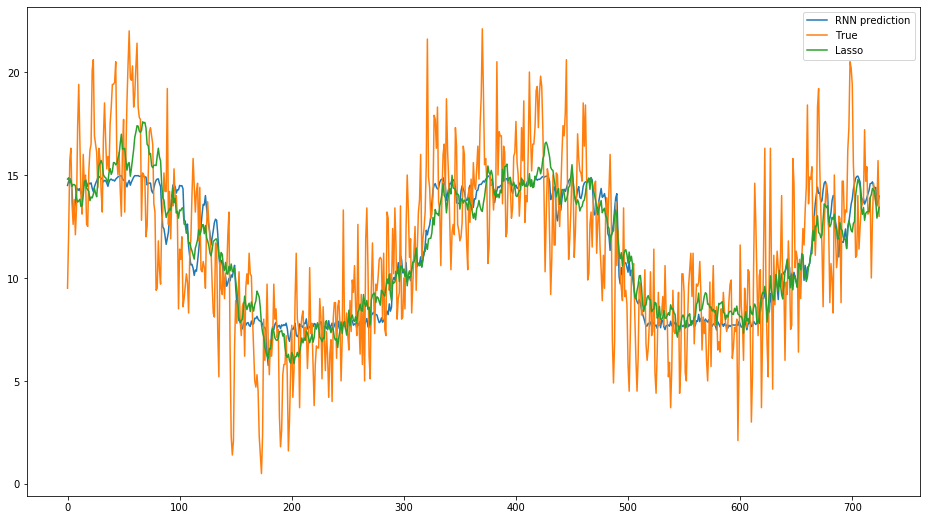

In [133]:
plt.figure(figsize=(16,9))
plt.plot(y_valid_test_rnn_model2.squeeze(), label = "RNN prediction")
plt.plot(y_test.values.squeeze(), label = "True")
plt.plot(y_test_pred_lasso, label = "Lasso")

plt.legend()

## 1.10) Plot the predictions

Make predictions on the validation set and plot them. Compare them to the targets and the baseline predictions.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 1 – Solution

## 1.1) Load the data

Let's start with a simple univariate time series: the daily temperatures in Melbourne from 1981 to 1990 ([source](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990)).

In [147]:
temps = pd.read_csv("datasets/daily-minimum-temperatures-in-me.csv",
                    parse_dates=[0], index_col=0)

In [148]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


In [149]:
temps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


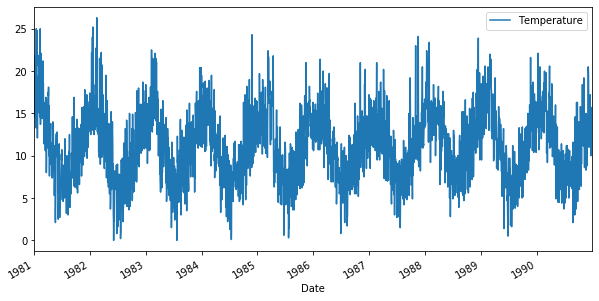

In [150]:
temps.plot(figsize=(10,5))
plt.show()

## 1.2) Prepare the data

A few dates are missing, for example December 31st, 1984:

In [151]:
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1985-01-01,13.3
1985-01-02,15.2


Let's ensure there's one row per day, filling missing values with the previous valid value:

In [152]:
temps = temps.asfreq("1D", method="ffill")
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1984-12-31,16.4
1985-01-01,13.3
1985-01-02,15.2


Alternatively, we could have interpolated using `temps.interpolate()`.

## 1.3) Add the shifted columns

Next, let's create a function to add lag columns:

In [153]:
def add_lags(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

In [154]:
add_lags(temps, times=(-2, -1, 0, +2)).head(10)

,t-2,t-1,t,t+2
,Temperature,Temperature,Temperature,Temperature
Date,,,,
1981-01-01,NaN,NaN,20.7,18.8
1981-01-02,NaN,20.7,17.9,14.6
1981-01-03,20.7,17.9,18.8,15.8
1981-01-04,17.9,18.8,14.6,15.8
1981-01-05,18.8,14.6,15.8,15.8
1981-01-06,14.6,15.8,15.8,17.4
1981-01-07,15.8,15.8,15.8,21.8
1981-01-08,15.8,15.8,17.4,20.0


We will try to predict the temperature in 5 days (t+5) using the temperatures from the last 30 days (t-29 to t):

In [155]:
X = add_lags(temps, times=range(-30+1,1)).iloc[30:-5]
y = add_lags(temps, times=[5]).iloc[30:-5]

In [156]:
X.head()

,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,...,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,12.1,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4
1981-02-01,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3
1981-02-02,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8
1981-02-03,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9
1981-02-04,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9,19.9


In [157]:
y.head()

,t+5
,Temperature
Date,
1981-01-31,16.6
1981-02-01,16.8
1981-02-02,14.6
1981-02-03,17.1
1981-02-04,25.0


## 1.4) Split the dataset

Let's split this dataset into three periods: training, validation and testing:

In [158]:
train_slice = slice(None, "1986-12-25")
valid_slice = slice("1987-01-01", "1988-12-25")
test_slice = slice("1989-01-01", None)

In [159]:
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_valid, y_valid = X.loc[valid_slice], y.loc[valid_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

## 1.5) Reshape the inputs for the RNN

Now let's create a function to reshape the multilevel DataFrames to 3D numpy arrays to feed to an RNN:

In [160]:
def multilevel_df_to_ndarray(df):
    shape = [-1] + [len(level) for level in df.columns.remove_unused_levels().levels]
    return df.values.reshape(shape)

In [161]:
X_train_3D = multilevel_df_to_ndarray(X_train)
X_valid_3D = multilevel_df_to_ndarray(X_valid)
X_test_3D = multilevel_df_to_ndarray(X_test)

In [162]:
X_train.shape

(2155, 30)

In [163]:
X_train_3D.shape

(2155, 30, 1)

## 1.6) Build some baseline models

Now let's evaluate some basic strategies, to get some baselines:

In [164]:
from sklearn.metrics import mean_absolute_error

In [165]:
def naive(X):
    return X.iloc[:, -1]

In [166]:
y_pred_naive = naive(X_valid)

In [167]:
mean_absolute_error(y_valid, y_pred_naive)

2.976551724137931

In [168]:
def ema(X, span):
    return X.T.ewm(span=span).mean().T.iloc[:, -1]

In [169]:
y_pred_ema = ema(X_valid, span=10)

In [170]:
mean_absolute_error(y_valid, y_pred_ema)

2.3581754113889133

In [171]:
from sklearn.linear_model import LinearRegression

In [172]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [173]:
y_pred_linear = lin_reg.predict(X_valid)

In [174]:
mean_absolute_error(y_valid, y_pred_linear)

2.2606549856754157

Let's plot these predictions:

In [175]:
def plot_predictions(*named_predictions, start=None, end=None, **kwargs):
    day_range = slice(start, end)
    plt.figure(figsize=(10,5))
    for name, y_pred in named_predictions:
        if hasattr(y_pred, "values"):
            y_pred = y_pred.values
        plt.plot(y_pred[day_range], label=name, **kwargs)
    plt.legend()
    plt.show()

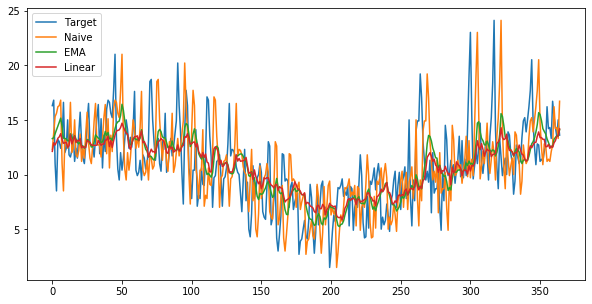

In [176]:
plot_predictions(("Target", y_valid),
                 ("Naive", y_pred_naive),
                 ("EMA", y_pred_ema),
                 ("Linear", y_pred_linear),
                 end=365)

## 1.7) Build a simple RNN

Let's create a simple 2-layer RNN with 100 neurons per layer, plus a dense layer with a single neuron:

In [203]:
input_shape = X_train_3D.shape[1:]
input_shape

(30, 1)

In [178]:
model1 = keras.models.Sequential()
model1.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model1.add(keras.layers.SimpleRNN(50))
model1.add(keras.layers.Dense(1))
model1.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.005), metrics=["mae"])

In [ ]:
history1 = model1.fit(X_train_3D, y_train, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, y_valid))

## 1.8) Plot the history

In [179]:
def plot_history(history, loss="loss"):
    train_losses = history.history[loss]
    valid_losses = history.history["val_" + loss]
    n_epochs = len(history.epoch)
    minloss = np.min(valid_losses)
    
    plt.plot(train_losses, color="b", label="Train")
    plt.plot(valid_losses, color="r", label="Validation")
    plt.plot([0, n_epochs], [minloss, minloss], "k--",
             label="Min val: {:.2f}".format(minloss))
    plt.axis([0, n_epochs, 0, 20])
    plt.legend()
    plt.show()

In [180]:
plot_history(history1)

NameError: name 'history1' is not defined

## 1.9) Evaluate the model

In [ ]:
model1.evaluate(X_valid_3D, y_valid)

In [181]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

In [ ]:
model1 = keras.models.Sequential()
model1.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model1.add(keras.layers.SimpleRNN(100))
model1.add(keras.layers.Dense(1))
model1.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.005), metrics=["mae"])

In [ ]:
history1 = model1.fit(X_train_3D, y_train, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, y_valid))

In [ ]:
model1.evaluate(X_valid_3D, y_valid)

## 1.10) Plot the predictions

In [182]:
y_pred_rnn1 = model1.predict(X_valid_3D)

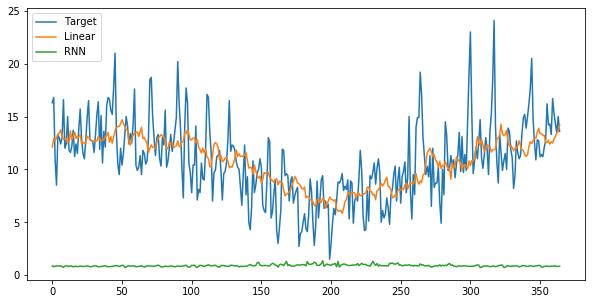

In [183]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn1),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 2 – Forecasting the shifted sequence (Seq2Seq)

Now let's predict temperatures for 30 days (from t-24 to t+5) instead of just one.

## 2.1) Define the 3D targets for training, validation and testing

In [ ]:
#Y_train_3D = ...
#Y_valid_3D = ...
#Y_test_3D = ...

## 2.2) Define an `mae_last_step()` function

For the final evaluation, we only want to look at the final time step (t+5). Create an `mae_last_step()` function that computes the MAE based on the final time step.

## 2.3) Build a Seq2Seq model

Build a Seq2Seq model and compile it, using the Huber Loss, and using the last step MAE as the metric. Use SGD with a learning rate of 0.01. Hint: the layers are the same as earlier, except that the last RNN layer has `return_sequences=False`, and the `Dense` layer must be wrapped in a `keras.layers.TimeDistributed` layer.

## 2.4) Train the model

Fit the model as earlier (but with the 3D targets). Again, evaluate the model and plot the predictions.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 2 – Solution

## 2.1) Define the 3D targets for training, validation and testing

In [189]:
Y = add_lags(temps, times=range(-24, 5+1)).iloc[30:-5]
Y_train = Y.loc[train_slice]
Y_valid = Y.loc[valid_slice]
Y_test = Y.loc[test_slice]
Y_train_3D = multilevel_df_to_ndarray(Y_train)
Y_valid_3D = multilevel_df_to_ndarray(Y_valid)
Y_test_3D = multilevel_df_to_ndarray(Y_test)

## 2.2) Define an `mae_last_step()` function

For the final evaluation, we only want to look at the final time step (t+5):

In [185]:
K = keras.backend

def mae_last_step(Y_true, Y_pred):
    return K.mean(K.abs(Y_pred[:, -1] - Y_true[:, -1]))

## 2.3) Build a Seq2Seq model

In [ ]:
model2 = keras.models.Sequential()
model2.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model2.add(keras.layers.SimpleRNN(100, return_sequences=True))
model2.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
model2.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

## 2.4) Train the model

In [ ]:
history2 = model2.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, Y_valid_3D))

In [ ]:
plot_history(history2, loss="mae_last_step")

In [ ]:
model2.evaluate(X_valid_3D, Y_valid_3D)

In [ ]:
y_pred_rnn2 = model2.predict(X_valid_3D)[:, -1]

In [ ]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn2),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 3 – LSTM and GRU

## 3.1) Build, train and evaluate a Seq2Seq LSTM

Train the same model as earlier but using `LSTM` or `GRU` instead of `SimpleRNN`. You can also try reducing the learning rate when the validation loss reaches a plateau, using the `ReduceLROnPlateau` callback.

## 3.2) Add $\ell_2$ regularization

Add $\ell_2$ regularization to your RNN, using the layers' `kernel_regularizer` and `recurrent_regularizer` arguments, and the `l2()` function in `keras.regularizers`. Tip: use the `partial()` function in the `functools` package to avoid repeating the same arguments again and again.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 3 – Solution

## 3.1) Build, train and evaluate a Seq2Seq LSTM

You can try replacing `LSTM` with `GRU`.

In [191]:
model3 = keras.models.Sequential()
model3.add(keras.layers.LSTM(100, return_sequences=True, input_shape=input_shape))
model3.add(keras.layers.LSTM(100, return_sequences=True))
model3.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
model3.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

In [192]:
history3 = model3.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, Y_valid_3D),
                      callbacks=[keras.callbacks.ReduceLROnPlateau(verbose=1)])

Train on 2155 samples, validate on 725 samples
Epoch 1/200
2155/2155 [==============================] - 3s 1ms/sample - loss: 8.9364 - mae_last_step: 9.1110 - val_loss: 7.8589 - val_mae_last_step: 7.9052
Epoch 2/200
2155/2155 [==============================] - 1s 384us/sample - loss: 6.4774 - mae_last_step: 6.3408 - val_loss: 5.4323 - val_mae_last_step: 5.3068
Epoch 3/200
2155/2155 [==============================] - 1s 397us/sample - loss: 4.4789 - mae_last_step: 4.2518 - val_loss: 3.7446 - val_mae_last_step: 3.5261
Epoch 4/200
2155/2155 [==============================] - 1s 390us/sample - loss: 3.4455 - mae_last_step: 3.3276 - val_loss: 3.0492 - val_mae_last_step: 3.0097
Epoch 5/200
2155/2155 [==============================] - 1s 387us/sample - loss: 3.1301 - mae_last_step: 3.1079 - val_loss: 2.8651 - val_mae_last_step: 2.8879
Epoch 6/200
2155/2155 [==============================] - 1s 386us/sample - loss: 3.0540 - mae_last_step: 3.0988 - val_loss: 2.8058 - val_mae_last_step: 2.8228
E

KeyboardInterrupt: 

In [ ]:
model3.evaluate(X_valid_3D, Y_valid_3D)

In [ ]:
plot_history(history3, loss="mae_last_step")

In [ ]:
y_pred_rnn3 = model3.predict(X_valid_3D)[:, -1]

In [ ]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn3),
                 end=365)

## 3.2) Add $\ell_2$ regularization

In [187]:
from functools import partial

In [ ]:
RegularizedLSTM = partial(keras.layers.LSTM,
                          return_sequences=True,
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          recurrent_regularizer=keras.regularizers.l2(1e-4))

In [ ]:
model3 = keras.models.Sequential()
model3.add(RegularizedLSTM(100, input_shape=input_shape))
model3.add(RegularizedLSTM(100))
model3.add(keras.layers.Dense(1))
model3.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

In [ ]:
history3 = model3.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=100,
                      validation_data=(X_valid_3D, Y_valid_3D))

In [ ]:
model3.evaluate(X_valid_3D, Y_valid_3D)

In [ ]:
plot_history(history3)

In [ ]:
y_pred_rnn3 = model3.predict(X_valid_3D)[:, -1]

In [ ]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn3),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 4 – Preprocessing with 1D-ConvNets

At the beginning of your sequential model, add a `Conv1D` layer with 32 kernels of size 5, a `MaxPool1D` layer with pool size 5 and strides 2. Train and evaluate the model.

In [194]:
input_shape

(30, 1)

In [204]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Conv1D(kernel_size=5, filters=32, input_shape=input_shape))
model4.add(keras.layers.MaxPool1D(pool_size=5, strides=2))
model4.add(keras.layers.LSTM(100, return_sequences=True))
model4.add(keras.layers.LSTM(100, return_sequences=True))
model4.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
model4.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])
history4 = model4.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=100,
                      validation_data=(X_valid_3D, Y_valid_3D))

"""
model4 = keras.models.Sequential()
model4.add(keras.layers.Conv1D(32, kernel_size=5, input_shape=input_shape))
model4.add(keras.layers.MaxPool1D(pool_size=5, strides=2))
model4.add(keras.layers.LSTM(32, return_sequences=True))
model4.add(keras.layers.LSTM(32))
model4.add(keras.layers.Dense(1))
model4.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.005))
"""

Train on 2155 samples, validate on 725 samples
Epoch 1/200


InvalidArgumentError:  Incompatible shapes: [100,30,1] vs. [100,11,1]
	 [[node loss_22/time_distributed_10_loss/sub (defined at /home/yang/Projects/perso/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1694) ]] [Op:__inference_keras_scratch_graph_228825]

Function call stack:
keras_scratch_graph


![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 4 – Solution

In [205]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Conv1D(32, kernel_size=5, input_shape=input_shape)) 
# we could also use padding="causal" to fill initial na
model4.add(keras.layers.MaxPool1D(pool_size=5, strides=2))
model4.add(keras.layers.LSTM(32, return_sequences=True))
model4.add(keras.layers.LSTM(32))
model4.add(keras.layers.Dense(1))
model4.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.005))

In [ ]:
model4.summary()

In [206]:
history4 = model4.fit(X_train_3D, y_train, epochs=200, batch_size=100,
                      validation_data=(X_valid_3D, y_valid))

Train on 2155 samples, validate on 725 samples
Epoch 1/200
2155/2155 [==============================] - 2s 1ms/sample - loss: 9.2591 - val_loss: 8.9638
Epoch 2/200
2155/2155 [==============================] - 0s 117us/sample - loss: 7.9226 - val_loss: 7.6954
Epoch 3/200
2155/2155 [==============================] - 0s 114us/sample - loss: 6.6937 - val_loss: 6.3991
Epoch 4/200
2155/2155 [==============================] - 0s 115us/sample - loss: 5.4595 - val_loss: 5.1001
Epoch 5/200
2155/2155 [==============================] - 0s 114us/sample - loss: 4.3418 - val_loss: 4.0179
Epoch 6/200
2155/2155 [==============================] - 0s 113us/sample - loss: 3.5482 - val_loss: 3.2926
Epoch 7/200
2155/2155 [==============================] - 0s 116us/sample - loss: 3.1080 - val_loss: 2.8836
Epoch 8/200
2155/2155 [==============================] - 0s 130us/sample - loss: 2.8928 - val_loss: 2.6851
Epoch 9/200
2155/2155 [==============================] - 0s 120us/sample - loss: 2.7991 - val_loss:

2155/2155 [==============================] - 0s 131us/sample - loss: 1.9170 - val_loss: 1.7809
Epoch 77/200
2155/2155 [==============================] - 0s 118us/sample - loss: 1.8965 - val_loss: 1.7966
Epoch 78/200
2155/2155 [==============================] - 0s 130us/sample - loss: 1.9102 - val_loss: 1.8273
Epoch 79/200
2155/2155 [==============================] - 0s 127us/sample - loss: 1.9098 - val_loss: 1.7694
Epoch 80/200
2155/2155 [==============================] - 0s 134us/sample - loss: 1.9073 - val_loss: 1.8459
Epoch 81/200
2155/2155 [==============================] - 0s 118us/sample - loss: 1.8910 - val_loss: 1.8285
Epoch 82/200
2155/2155 [==============================] - 0s 124us/sample - loss: 1.8988 - val_loss: 1.9284
Epoch 83/200
2155/2155 [==============================] - 0s 131us/sample - loss: 1.8842 - val_loss: 1.8615
Epoch 84/200
2155/2155 [==============================] - 0s 120us/sample - loss: 1.8955 - val_loss: 1.8344
Epoch 85/200
2155/2155 [=================

2155/2155 [==============================] - 0s 120us/sample - loss: 1.8291 - val_loss: 1.7782
Epoch 152/200
2155/2155 [==============================] - 0s 119us/sample - loss: 1.8787 - val_loss: 1.7638
Epoch 153/200
2155/2155 [==============================] - 0s 115us/sample - loss: 1.8506 - val_loss: 1.8223
Epoch 154/200
2155/2155 [==============================] - 0s 118us/sample - loss: 1.8536 - val_loss: 1.7428
Epoch 155/200
2155/2155 [==============================] - 0s 125us/sample - loss: 1.8564 - val_loss: 1.7480
Epoch 156/200
2155/2155 [==============================] - 0s 115us/sample - loss: 1.8486 - val_loss: 1.7904
Epoch 157/200
2155/2155 [==============================] - 0s 117us/sample - loss: 1.8569 - val_loss: 1.7589
Epoch 158/200
2155/2155 [==============================] - 0s 115us/sample - loss: 1.8365 - val_loss: 1.8303
Epoch 159/200
2155/2155 [==============================] - 0s 116us/sample - loss: 1.8624 - val_loss: 1.7940
Epoch 160/200
2155/2155 [========

In [207]:
model4.evaluate(X_valid_3D, y_valid)

725/725 [==============================] - 1s 1ms/sample - loss: 1.7406


1.7406053730537152

In [208]:
mean_absolute_error(y_valid, model4.predict(X_valid_3D))

2.1859648219141468

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercice 5 – Sequence classification

Let's load the IMDB movie reviews, for binary sentiment analysis (positive review or negative review):

We only want the 10,000 most common words:

In [209]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

17465344/17464789 [==============================] - 8s 0us/step


Let's also get the word index (word to word id):

In [210]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 1s 0us/step


And let's create a reverse index (word id to word). Three special word ids are added:

In [211]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

Let's write a little function to decode reviews:

In [212]:
def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's look at a review:

In [213]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

It seems very positive, let's look at the target (0=negative review, 1=positive review):

In [214]:
y_train[0]

1

And another review:

In [215]:
decode_review(X_train[1])

"<sos> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <oov> the hair is big lots of boobs <oov> men wear those cut <oov> shirts that show off their <oov> sickening that men actually wore them and the music is just <oov> trash that plays over and over again in almost every scene there is trashy music boobs and <oov> taking away bodies and the gym still doesn't close for <oov> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

Very negative! Let's check the target:

In [216]:
y_train[1]

0

## 5.1) Train a baseline model

Train and evaluate a baseline model using ScikitLearn. You will need to create a pipeline with a `CountVectorizer`, a `TfidfTransformer` and an `SGDClassifier`. The `CountVectorizer` transformer expects text as input, so let's create a text version of the training set and test set:

In [217]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

In [218]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [230]:
clf = Pipeline([('count', CountVectorizer(ngram_range = (1, 3))), ('tfidf', TfidfTransformer()), ('SGDC', SGDClassifier())])

In [231]:
clf.fit(X_train_text, y_train)
y_pred = clf.predict(X_test_text)

In [232]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.88856

## 5.2) Create a sequence classifier

Create a sequence classifier using Keras:
* Use `keras.preprocessing.sequence.pad_sequences()` to preprocess `X_train`: this will create a 2D array of 25,000 rows (one per review) and `maxlen=500` columns. Reviews longer than 500 words will be cropped, while reviews shorter 
than 500 words will be padded with zeros.
* The first layer in your model should be an `Embedding` layer, with `input_dim=num_words` and `output_dim=10`. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batchs of shape (batch size, 500, 10).
* Add one or more LSTM layers with 32 neurons each.
* The output layer should be a Dense layer with a sigmoid activation function, since this is a binary classification problem.
* When compiling the model, you should use the `binary_crossentropy` loss.
* Fit the model for 10 epochs, using a batch size of 128 and `validation_split=0.2`.

In [235]:
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=500)

In [236]:
X_train_padded.shape

(25000, 500)

In [239]:
num_words=10000
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(units=32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [240]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=0.0001), metrics=["acc"])
model.fit(X_train_padded, y_train, batch_size=128, validation_split=0.2, epochs=10)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 30s 1ms/sample - loss: 0.6929 - acc: 0.5221 - val_loss: 0.6924 - val_acc: 0.5652
Epoch 2/10
20000/20000 [==============================] - 30s 2ms/sample - loss: 0.6901 - acc: 0.6205 - val_loss: 0.6824 - val_acc: 0.6342
Epoch 3/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.6183 - acc: 0.7221 - val_loss: 0.5915 - val_acc: 0.7584
Epoch 4/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.5460 - acc: 0.8074 - val_loss: 0.5113 - val_acc: 0.8158
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.4749 - acc: 0.8313 - val_loss: 0.4588 - val_acc: 0.8194
Epoch 6/10
20000/20000 [==============================] - 32s 2ms/sample - loss: 0.3999 - acc: 0.8564 - val_loss: 0.3991 - val_acc: 0.8504
Epoch 7/10
20000/20000 [==============================] - 32s 2ms/sample - loss: 0.3577 - acc: 0.8738 - val_loss: 0.4

In [244]:
model.fit(X_train_padded, y_train, batch_size=128, validation_split=0.2, epochs=10)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 28s 1ms/sample - loss: 0.2607 - acc: 0.9111 - val_loss: 0.3378 - val_acc: 0.8668
Epoch 2/10
20000/20000 [==============================] - 30s 1ms/sample - loss: 0.2427 - acc: 0.9184 - val_loss: 0.3214 - val_acc: 0.8716
Epoch 3/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.2293 - acc: 0.9240 - val_loss: 0.3149 - val_acc: 0.8788
Epoch 4/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.2141 - acc: 0.9305 - val_loss: 0.3124 - val_acc: 0.8774
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.2036 - acc: 0.9343 - val_loss: 0.3321 - val_acc: 0.8770
Epoch 6/10
20000/20000 [==============================] - 32s 2ms/sample - loss: 0.1918 - acc: 0.9390 - val_loss: 0.3137 - val_acc: 0.8820
Epoch 7/10
20000/20000 [==============================] - 32s 2ms/sample - loss: 0.1843 - acc: 0.9415 - val_loss: 0.3

In [245]:
tb=keras.callbacks.TensorBoard(embeddings_freq=1)

In [246]:
X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=500)
y_pred = model.predict(X_test_padded)
# accuracy_score(y_test, y_pred)

In [247]:
accuracy_score(y_test, y_pred>0.5)

0.8648

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercice 5 – Solution

## 5.1) Train a baseline model

In [ ]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=50)),
])

In [ ]:
pipeline.fit(X_train_text, y_train)

In [ ]:
pipeline.score(X_test_text, y_test)

We get 88.5% accuracy, that's not too bad. But don't forget to check the ratio of positive reviews:

In [ ]:
y_test.mean()

Let's try our model:

In [ ]:
pipeline.predict(["this movie was really awesome"])

## 5.2) Create a sequence classifier

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

In [ ]:
model.evaluate(X_test_trim, y_test)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 6 – Bidirectional RNN

Update the previous sequence classification model to use a bidirectional LSTM. For this, you just need to wrap the LSTM layer in a `Bidirectional` layer. If the model overfits, try adding a dropout layer.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 6 – Solution

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

In [ ]:
model.evaluate(X_test_trim, y_test)